## 10.1 注意力提示

In [3]:
import tensorflow as tf
from d2l import tensorflow as d2l

In [4]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

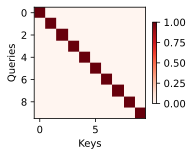

In [5]:
attention_weights = tf.reshape(tf.eye(10), (1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [6]:
attention_weights

<tf.Tensor: shape=(1, 1, 10, 10), dtype=float32, numpy=
array([[[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]]]], dtype=float32)>

In [31]:
matrices = attention_weights

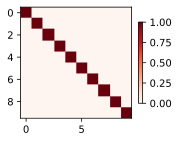

In [33]:
cmap='Reds'
xlabel='Keys'
ylabel='Queries'
titles =None
num_rows =1 
num_cols = 1
fig, axes = d2l.plt.subplots(1, 1, figsize=(2.5,2.5),sharex=True, sharey=True, squeeze=False)
for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
    for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
        pcm = ax.imshow(matrix.numpy(), cmap=cmap)
        # if i == num_rows - 1:
        #     ax.set_xlabel(xlabel)
        # if j == 0:
        #     ax.set_ylabel(ylabel)
        # if titles:
        #     ax.set_title(titles[j])
fig.colorbar(pcm, ax=axes, shrink=0.6);

## 10.2. 注意力汇聚：Nadaraya-Watson 核回归
### 10.2.1 生成数据集

In [60]:
import tensorflow as tf
from d2l import tensorflow as d2l
import matplotlib.pyplot as plt

tf.random.set_seed(seed=1322)

n_train = 50
x_train = tf.sort(tf.random.uniform(shape=(n_train,), maxval=5))

def f(x):
    return 2 * tf.sin(x) + x**0.8

y_train = f(x_train) + tf.random.normal((n_train,), 0.0, 0.5)  # 训练样本的输出
x_test = tf.range(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

### 10.2.2 用平均聚合作为预估的函数值

In [61]:
y_hat = tf.repeat(tf.reduce_mean(y_train), repeats=n_test)

In [62]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

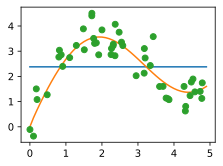

In [63]:
plt.plot(x_test,*[y_hat])
plt.plot(x_test,*[y_truth])
plt.plot(x_train,*[y_train],'o')

### 10.2.3. 非参数注意力汇聚

为了更好地理解注意力汇聚，
下面考虑一个*高斯核*（Gaussian kernel），其定义为：

$$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2}).$$

将高斯核代入可以得到：

$$\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}$$

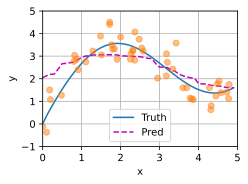

In [64]:
# X_repeat的形状:(50, 50),
# 每行都是一个完整的相同的（1，50）测试输入数据
# X_repeat与（1，50）中每个元素x_i，并行化计算其在x_i点的权重矩阵
# 每一行都包含着相同的测试输入（例如：同样的query）


X_repeat = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# x_train包含着键。attention_weights的形状：(50,50),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = tf.nn.softmax(-(X_repeat - tf.expand_dims(x_train, axis=1))**2/2, axis=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = tf.matmul(attention_weights, tf.expand_dims(y_train, axis=1))
plot_kernel_reg(y_hat)

In [65]:
# 每行都是一个query（1，50）, 行和为1
tf.reduce_sum(attention_weights,axis=1)

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([1.0000001 , 0.99999994, 1.0000001 , 1.        , 1.        ,
       0.99999994, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999994, 1.        ,
       0.99999994, 0.99999994, 1.0000001 , 0.99999994, 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.99999994,
       1.        , 1.        , 0.99999994, 0.99999994, 1.0000001 ,
       1.        , 0.9999999 , 1.0000001 , 0.99999994, 1.0000001 ,
       1.        , 1.        , 0.99999994, 1.        , 0.99999994,
       1.        , 1.        , 0.9999999 , 1.0000002 , 0.99999994,
       1.        , 1.        , 0.9999999 , 1.        , 1.        ],
      dtype=float32)>

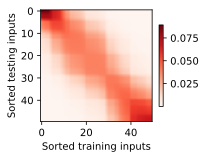

In [66]:
d2l.show_heatmaps(tf.expand_dims(
                      tf.expand_dims(attention_weights, axis=0), axis=0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

### 10.2.4. 带参数注意力汇聚
非参数的Nadaraya-Watson核回归具有*一致性*（consistency）的优点：
如果有足够的数据，此模型会收敛到最优结果。
尽管如此，我们还是可以轻松地将可学习的参数集成到注意力汇聚中。

例如，与上面略有不同，
在下面的查询$x$和键$x_i$之间的距离乘以可学习参数$w$：

$$\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}$$


本节的余下部分将通过训练这个模型来学习注意力汇聚的参数。

#### 10.2.4.1 批量矩阵乘法
假定两个张量的形状分别是 (𝑛,𝑎,𝑏) 和 (𝑛,𝑏,𝑐) ， 它们的批量矩阵乘法输出的形状为 (𝑛,𝑎,𝑐) ]。

In [67]:
X = tf.ones((2, 1, 4))
Y = tf.ones((2, 4, 6))
tf.matmul(X, Y).shape

TensorShape([2, 1, 6])

在注意力机制的背景中，我们可以[**使用小批量矩阵乘法来计算小批量数据中的加权平均值**]。


In [78]:
weights = tf.ones((2, 10)) * 0.1   # (2,10)
values = tf.reshape(tf.range(20.0), shape = (2, 10)) # (2,10)
tf.matmul(tf.expand_dims(weights, axis=1), tf.expand_dims(values, axis=-1)).numpy() # (2,1,10) * (2,10,1) -->(2,1,1)

array([[[ 4.5]],

       [[14.5]]], dtype=float32)

#### 10.2.4.2 定义模型
基于带参数的注意力汇聚，使用小批量矩阵乘法， 定义Nadaraya-Watson核回归的带参数版本为：

In [94]:
class NWKernelRegression(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = tf.Variable(initial_value=tf.random.uniform(shape=(1,)))

    def call(self, queries, keys, values, **kwargs):
        # 对于训练，“查询”是x_train,即全部数据点组成的查询表。“键”是每个点的训练数据的距离。“值”为'y_train'。
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = tf.repeat(tf.expand_dims(queries, axis=1), repeats=keys.shape[1], axis=1)
        self.attention_weights = tf.nn.softmax(-((queries - keys) * self.w)**2 /2, axis =1)
        # values的形状为(查询个数，“键－值”对个数)
        return tf.squeeze(tf.matmul(tf.expand_dims(self.attention_weights, axis=1), tf.expand_dims(values, axis=-1)))

#### 10.2.4.3训练

接下来，[**将训练数据集变换为键和值**]用于训练注意力模型。
在带参数的注意力汇聚模型中，
任何一个训练样本的输入都会和除自己以外的所有训练样本的“键－值”对进行计算，
从而得到其对应的预测输出。


In [79]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_train, axis=0)
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_train, axis=0)
# keys的形状:('n_train'，'n_train'-1)
keys = tf.reshape(X_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = tf.reshape(Y_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))

In [91]:
X_tile

<tf.Tensor: shape=(50, 50), dtype=float32, numpy=
array([[1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       ...,
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00]], dtype=float32)>

In [90]:
X_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)]

<tf.Tensor: shape=(2450,), dtype=float32, numpy=
array([0.09995282, 0.1777476 , 0.19972622, ..., 4.5800347 , 4.7272196 ,
       4.772985  ], dtype=float32)>

In [92]:
tf.reshape(X_tile[tf.cast(1 - tf.eye(n_train), dtype=tf.bool)], shape=(n_train, -1))

<tf.Tensor: shape=(50, 49), dtype=float32, numpy=
array([[9.9952817e-02, 1.7774761e-01, 1.9972622e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 1.7774761e-01, 1.9972622e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.9972622e-01, ..., 4.7272196e+00,
        4.7729850e+00, 4.7854233e+00],
       ...,
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.5800347e+00,
        4.7729850e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.5800347e+00,
        4.7272196e+00, 4.7854233e+00],
       [1.6874075e-03, 9.9952817e-02, 1.7774761e-01, ..., 4.5800347e+00,
        4.7272196e+00, 4.7729850e+00]], dtype=float32)>

训练带参数的注意力汇聚模型时，使用平方损失函数和随机梯度下降。

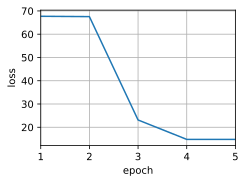

In [95]:
net = NWKernelRegression()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])


for epoch in range(5):
    with tf.GradientTape() as t:
        loss = loss_object(y_train, net(x_train, keys, values)) * len(y_train)
    grads = t.gradient(loss, net.trainable_variables)
    optimizer.apply_gradients(zip(grads, net.trainable_variables))
    print(f'epoch {epoch + 1}, loss {float(loss):.6f}')
    animator.add(epoch + 1, float(loss))

如下所示，训练完带参数的注意力汇聚模型后可以发现： 在尝试拟合带噪声的训练数据时， 预测结果绘制的线不如之前非参数模型的平滑。

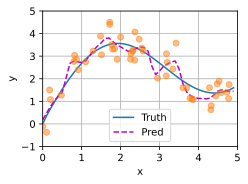

In [96]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = tf.repeat(tf.expand_dims(x_train, axis=0), repeats=n_test, axis=0)
# value的形状:(n_test，n_train)
values = tf.repeat(tf.expand_dims(y_train, axis=0), repeats=n_test, axis=0)
y_hat = net(x_test, keys, values)
plot_kernel_reg(y_hat)

## 10.3 注意力评分函数
10.2节使用了高斯核来对查询和键之间的关系建模。 (10.2.6)中的 高斯核指数部分可以视为注意力评分函数（attention scoring function）， 简称评分函数（scoring function）， 然后把这个函数的输出结果输入到softmax函数中进行运算。 通过上述步骤，**将得到与键对应的值的概率分布（即注意力权重）**。 最后，注意力汇聚的输出就是基于这些注意力权重的值的加权和。

正如上图所示，选择不同的注意力评分函数
会导致不同的注意力汇聚操作。 本节将介绍两个流行的评分函数，稍后将用他们来实现更复杂的注意力机制。

In [ ]:
import tensorflow as tf
from d2l import tensorflow as d2l

### 10.3.1. 掩蔽softmax操作¶
正如上面提到的，softmax操作用于输出一个概率分布作为注意力权重。 在某些情况下，并非所有的值都应该被纳入到注意力汇聚中。 例如，为了在 9.5节中高效处理小批量数据集， 某些文本序列被填充了没有意义的特殊词元。 为了仅将有意义的词元作为值来获取注意力汇聚， 可以指定一个有效序列长度（即词元的个数）， 以便在计算softmax时过滤掉超出指定范围的位置。 下面的masked_softmax函数 实现了这样的掩蔽softmax操作（masked softmax operation）， 其中任何超出有效长度的位置都被掩蔽并置为0。

In [97]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(tf.reshape(X, shape=(-1, shape[-1])),
                              valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)